### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [ ]:
#!L
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 1.4 gb file, downloading will take some time
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

    # alternative way: 
    #from gfile import download_list
    #download_list(url=https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW,
    #               filename=FILENAME, target_dir=TARGET_DIR)

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
GB = 2**30
assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [ ]:
#!L:bash
unzip celeba.zip

In [1]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = 'cuda:1'
print("Torch version:", torch.__version__)

Torch version: 1.9.0+cu111


### Prepare Dataset

In [2]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

IMG_SHAPE = tuple(train_dataset[0][0].shape)

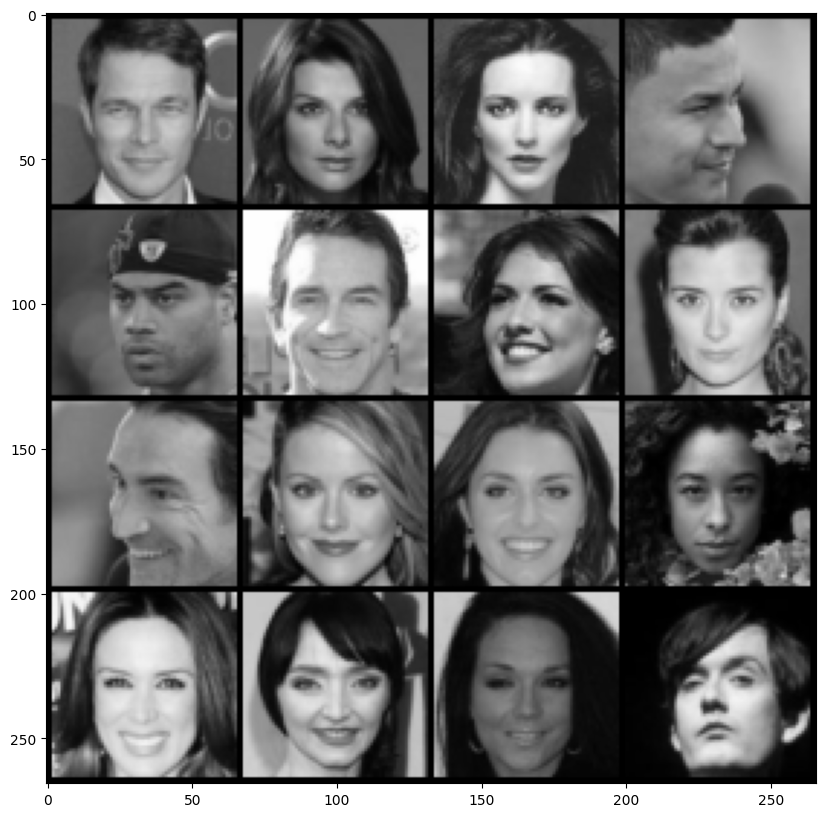

In [4]:
#!L
# print some images
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [5]:
#!L
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE).to(device)
    return noise
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [6]:
#!L
CODE_SIZE = 128 # Size of z noise vector; feel free to change it

generator = nn.Sequential(
    nn.Linear(CODE_SIZE, 1024),
    nn.ELU(),
    Reshape([-1, 16, 8, 8]),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,3), padding=1),
    nn.ELU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(in_channels=8, out_channels=4, kernel_size=(3,3), padding=1),
    nn.ELU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(in_channels=4, out_channels=2, kernel_size=(3,3), padding=1),
    nn.ELU(),
    nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(3,3), padding=1),
    nn.Sigmoid()
)

## YOUR CODE - create architecture for discriminator
## Note: please start simple. You can start with the layers below, but you are more than welcome to change it


##TODO: define next layers

generator.to(device)

Sequential(
  (0): Linear(in_features=128, out_features=1024, bias=True)
  (1): ELU(alpha=1.0)
  (2): Reshape()
  (3): Upsample(scale_factor=2.0, mode=nearest)
  (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ELU(alpha=1.0)
  (6): Upsample(scale_factor=2.0, mode=nearest)
  (7): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ELU(alpha=1.0)
  (9): Upsample(scale_factor=2.0, mode=nearest)
  (10): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ELU(alpha=1.0)
  (12): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Sigmoid()
)

In [7]:
#!L
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [8]:
#!L
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.to(device)

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [9]:
#!L
discriminator = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=2),
    nn.ELU(),
    nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=2),
    nn.ELU(),
    nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=2),
    nn.ELU(),
    Flatten(),
    nn.Linear(512, 128),
    nn.ELU(),
    nn.Linear(128, 1),
)

## YOUR CODE - create convolutional architecture for discriminator
## Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

discriminator.to(device)

Sequential(
  (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ELU(alpha=1.0)
  (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ELU(alpha=1.0)
  (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): ELU(alpha=1.0)
  (9): Flatten()
  (10): Linear(in_features=512, out_features=128, bias=True)
  (11): ELU(alpha=1.0)
  (12): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
#!L
discriminator(sample_data_batch(4)).shape

/home/dsorokin/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([4, 1])

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [11]:
#!L
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = -logp_gen_is_real.mean()
    
    return loss

In [12]:
#!L
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.6724, device='cuda:1', grad_fn=<NegBackward>)


In [13]:
#!L
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(-disc_on_fake_data)

    loss = -logp_real_is_real.mean() - logp_gen_is_fake.mean()
    return loss

In [14]:
#!L
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(1.3845, device='cuda:1', grad_fn=<SubBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [15]:
#!L
import numpy as np


def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()
    
def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()


### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [16]:
#!L
# optimizers
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

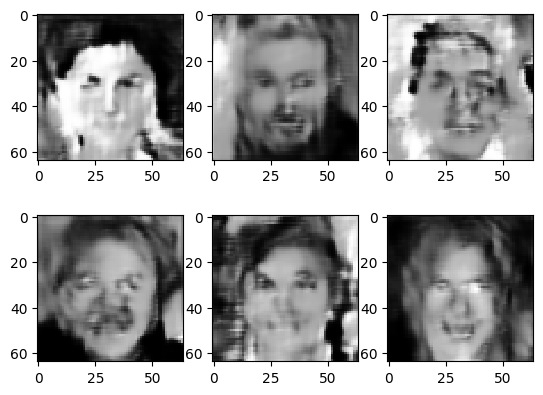

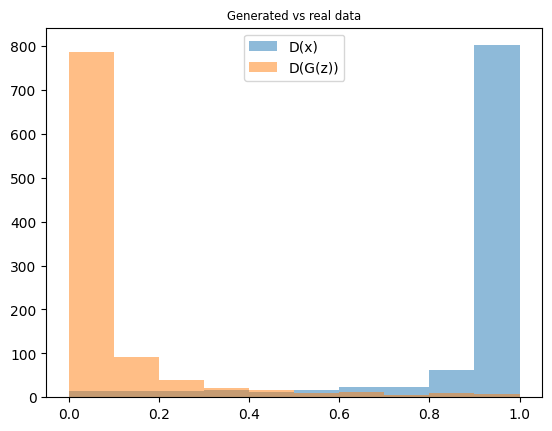

In [ ]:
#!L
from IPython import display
from tqdm import trange

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in trange(128):
    for iteration, (batch, _) in enumerate(loader):

        # Train discriminator
        real_data = batch.to(device)
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()

        # Train generator
        if iteration % 5 == 0:
            noise = sample_noise_batch(batch_size)
            loss = generator_loss(noise)
            gen_opt.zero_grad()
            loss.backward()
            gen_opt.step()

        if iteration % 100 == 0:
            print(epoch)
            display.clear_output(wait=True)
            sample_images(2,3,True)
            sample_probas(1000)
        

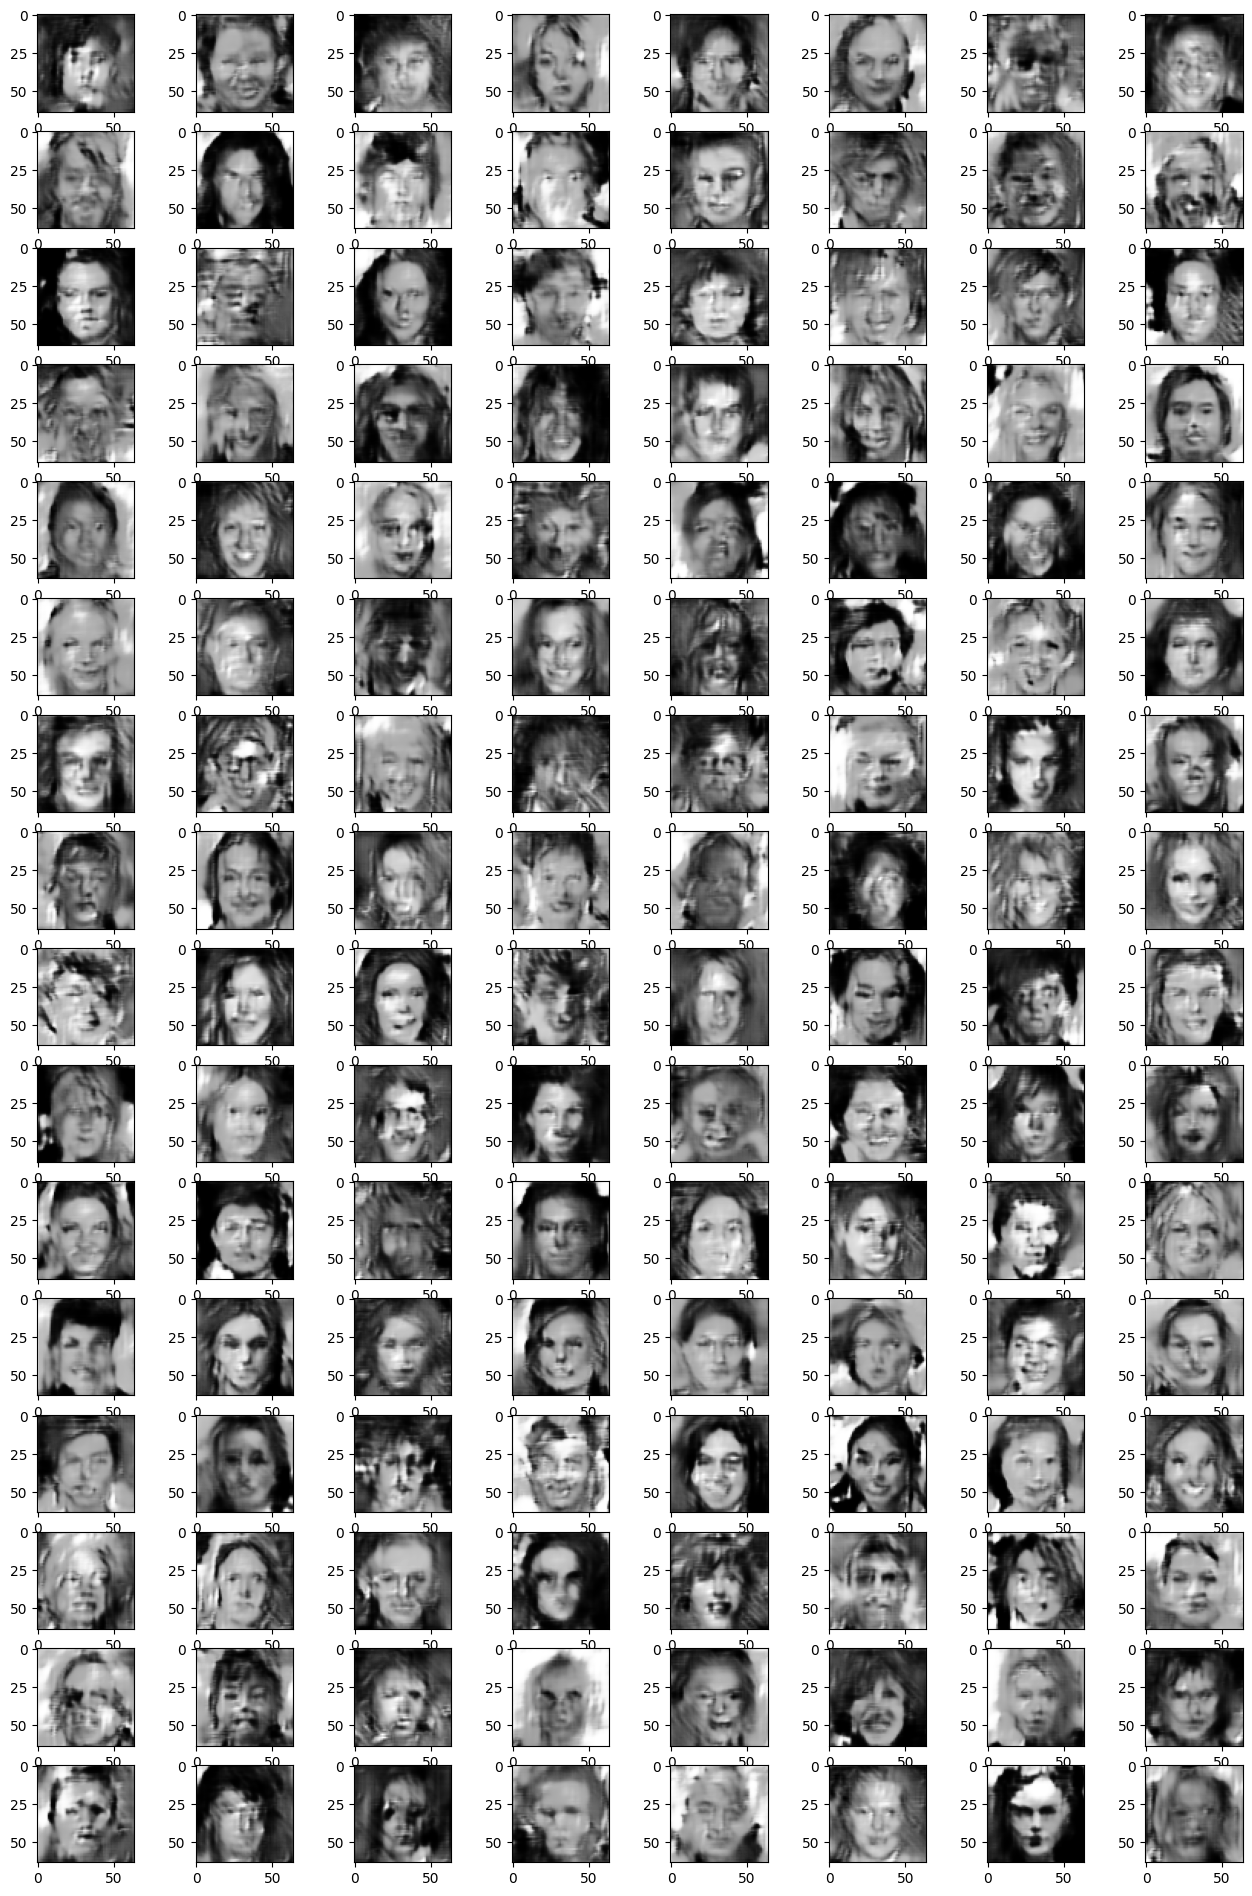

In [20]:
#!L
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better